In [7]:
import arviz as az
import os
import matplotlib.pyplot as plt
import pickle
from matplotlib import rc
import matplotlib.lines as mlines
import numpy as np
from typing import List, Optional

In [230]:
plt.style.use('default')
plt.rcParams['font.size'] = 12.0
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.linewidth'] = 0.4
plt.rcParams['lines.linewidth'] = 0.4
plt.rcParams['xtick.labelsize'] = 10
rc('text', usetex=True)

In [4]:
class emcee_result:
    

    def __init__(self, filename):
        idata = az.from_netcdf(filename)
        self.idata = idata
        self.dim = len(idata.posterior)
        
    def trace(self, axes=None):
        
        var_dict = {"Omega_m" : r"$\Omega_{m,0}$",
                   "w_0" :  r"$w_0$",
                   "w_1" : r"$w_1$",
                   "alpha" : r"$\alpha$"}   
        
        labeller = az.labels.MapLabeller(var_name_map=var_dict)
        

        az.plot_trace(self.idata, axes=axes, labeller=labeller)

In [68]:
class numpyro_result:
    
    def __init__(self, filename):
        with open(filename, 'rb') as f:
            res_dict = pickle.load(f) 
        self.losses = res_dict['losses']
        self.samples = res_dict['samples']
        self.params = res_dict['params']
        self.quantiles = res_dict['quantiles']
        self.idata = az.from_dict(self.samples['param_11'])
        
    def plot_losses(self, ax=None, kwargs=dict()):
        if ax:
            ax.plot(self.losses, **kwargs)
        else:
            plt.plot(self.losses, **kwargs)
            
    def plot_samples(self, ax=None, all=True):
        
        par_dict =  {'param_0': '0',
                     'param_1': '100',
                     'param_2': '200',
                     'param_3': '300',
                     'param_4': '500',
                     'param_5': '1000',
                     'param_6': '1700',
                     'param_7': '2900',
                     'param_8': '5000',
                     'param_9': '8600',
                     'param_10': '14600',
                     'param_11': '25000'}
    
        if all == True:
            color = iter(plt.cm.rainbow(np.linspace(0, 1, len(self.samples.values()))))
            handles = []
            for i in self.samples.keys():
                s = self.samples[i]
                c = next(color)
                O = s['Omega_m']
                az.plot_kde(O, plot_kwargs=dict(color=c), ax=ax)
                label=par_dict[i]
                h = mlines.Line2D([], [], color=c, label=label)
                handles += [h]
            
            
        else:
            s = self.samples['param_11']['Omega_m']
            az.plot_kde(s, ax=ax)
         
        return handles

In [157]:
def plot_results(idata, burnin, var_names: Optional[List[str]] = None, kde_kwargs=None,
        marginal_kwargs=None, dist_kwargs=dict(), ax=None, name=None):
    
    var_dict = {"Omega_m" : r"$\Omega_{m,0}$",
                   "w_0" :  r"$w_0$",
                   "w_1" : r"$w_1$",
                   "alpha" : r"$\alpha$"}   
        
    labeller = az.labels.MapLabeller(var_name_map=var_dict)
    
    idata = idata.sel(draw=slice(burnin, None))

    if len(idata.posterior) == 1: 
        vals = np.concatenate(idata.posterior["Omega_m"].values)
        az.plot_dist(vals, ax=ax, label=name, **dist_kwargs)
    else:
        az.plot_pair(idata, kind='kde', marginals=True, figsize=(10,10), textsize=16, ax=ax, 
                    kde_kwargs=kde_kwargs, marginal_kwargs=marginal_kwargs, contour=False, labeller=labeller)

# Load $\Lambda$CDM data

In [69]:
data_dir_num = '../scripts/numpyro_results/'
lcdm_ni0p0 = numpyro_result(data_dir_num + 'lcdm_prior0_init_0_0.001.pickle')
lcdm_ni1p0 = numpyro_result(data_dir_num + 'lcdm_prior0_init_1_0.001.pickle')
lcdm_ni0p1 = numpyro_result(data_dir_num + 'lcdm_prior1_init_0_0.001.pickle')
lcdm_ni1p1 = numpyro_result(data_dir_num + 'lcdm_prior1_init_1_0.001.pickle')

In [56]:
data_dir_em = '../scripts/emcee_results/'
lcdm_ei0p0 = emcee_result(data_dir_em +'lcdm_init0_prior0.nc')
lcdm_ei0p1 = emcee_result(data_dir_em +'lcdm_init0_prior1.nc')
lcdm_ei1p0 = emcee_result(data_dir_em +'lcdm_init1_prior0.nc')
lcdm_ei1p1 = emcee_result(data_dir_em +'lcdm_init1_prior1.nc')

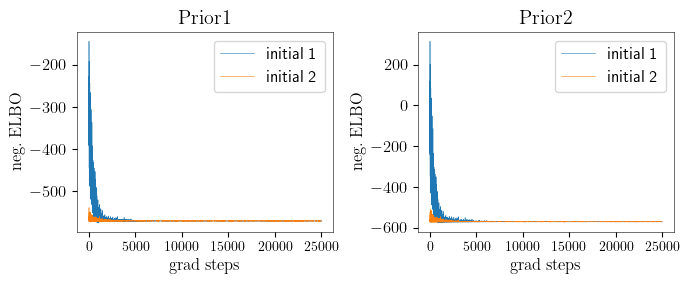

In [255]:
fig7, axes7 = plt.subplots(1,2, figsize=(7,3))

lcdm_ni0p0.plot_losses(axes7[0], kwargs={'label':'initial 1'})  
lcdm_ni1p0.plot_losses(axes7[0], kwargs={'label':'initial 2'})  

axes7[0].legend()
axes7[0].set_ylabel(r'$\mathrm{neg. \;ELBO}$')
axes7[0].set_xlabel(r'$\mathrm{grad\; steps}$')
axes7[0].set_title(r'$\mathrm{Prior 1}$')


lcdm_ni0p1.plot_losses(axes7[1], kwargs={'label':'initial 1'})  
lcdm_ni1p1.plot_losses(axes7[1],kwargs={'label':'initial 2'})  

axes7[1].legend()
axes7[1].set_ylabel(r'$\mathrm{neg. \;ELBO}$')
axes7[1].set_xlabel(r'$\mathrm{grad\; steps}$')
axes7[1].set_title(r'$\mathrm{Prior 2}$')
fig7.tight_layout()
fig7.savefig('../plots/lcdm_losses.pdf')

In [58]:
var_dict = {"Omega_m" : r"$\Omega_{m,0}$",
           "w_0" :  r"$w_0$",
           "w_1" : r"$w_1$",
           "alpha" : r"$\alpha$"}   
labeller = az.labels.MapLabeller(var_name_map=var_dict)

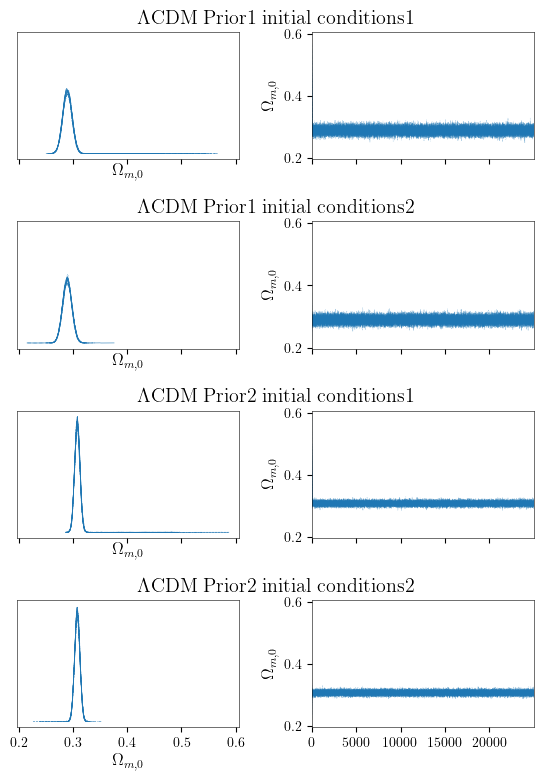

In [232]:
fig1, axes1 = plt.subplots(4,2, sharey='col', sharex='col', figsize=(5.6, 8))

ax1 = fig1.add_subplot(411, frameon=False)
ax1.set_title(r'$\Lambda\mathrm{CDM \; Prior 1 \; initial\; conditions 1}$')
ax1.set_xticks([])
ax1.set_yticks([])
az.plot_trace(lcdm_ei0p0.idata, axes=axes1[[0],:], labeller=labeller)

ax2 = fig1.add_subplot(412, frameon=False)
ax2.set_title(r'$\Lambda\mathrm{CDM \; Prior 1 \; initial\; conditions 2}$')
ax2.set_xticks([])
ax2.set_yticks([])
az.plot_trace(lcdm_ei1p0.idata, axes=axes1[[1],:], labeller=labeller)

ax3 = fig1.add_subplot(413, frameon=False)
ax3.set_title(r'$\Lambda\mathrm{CDM \; Prior 2 \; initial\; conditions 1}$')
ax3.set_xticks([])
ax3.set_yticks([])
az.plot_trace(lcdm_ei0p1.idata, axes=axes1[[2],:], labeller=labeller)

ax4 = fig1.add_subplot(414, frameon=False)
ax4.set_title(r'$\Lambda\mathrm{CDM \; Prior 2 \; initial \; conditions 2}$')
ax4.set_xticks([])
ax4.set_yticks([])
az.plot_trace(lcdm_ei1p1.idata, axes=axes1[[3],:], labeller=labeller)

for a in axes1:
    a[0].set_title('')
    a[1].set_title('')
    a[0].set_xlabel(r"$\Omega_{m,0}$")
    a[1].set_ylabel(r"$\Omega_{m,0}$")
        

fig1.tight_layout()
fig1.savefig('../plots/lcdm_trace.pdf')

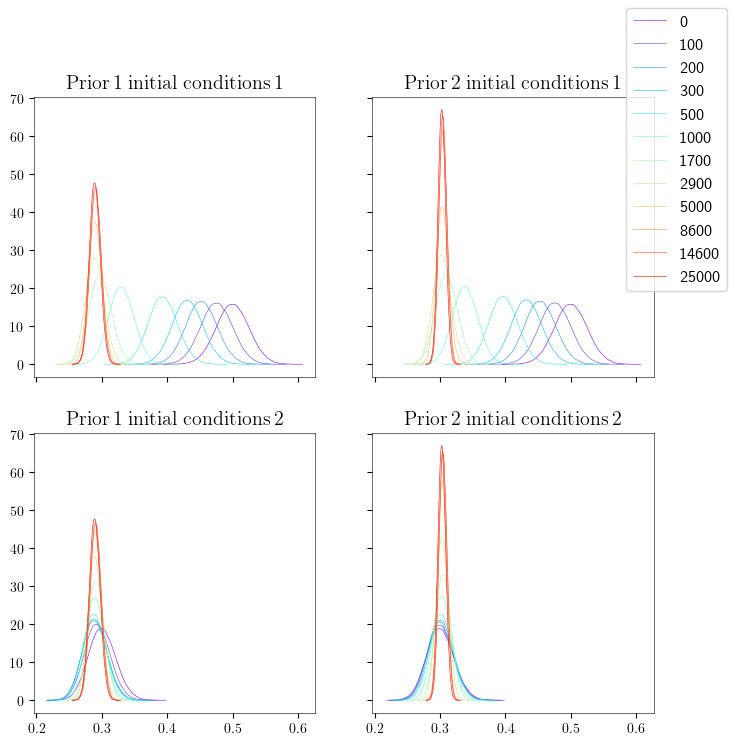

In [253]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
h = lcdm_ni0p0.plot_samples(axes2[0,0])
lcdm_ni0p1.plot_samples(axes2[0,1])
lcdm_ni1p0.plot_samples(axes2[1,0])
lcdm_ni1p1.plot_samples(axes2[1,1])

axes2[0,0].set_title(r'$\mathrm{Prior \,1 \; initial\; conditions \,1}$'),
axes2[0,1].set_title(r'$\mathrm{Prior \,2 \; initial\; conditions \,1}$'),
axes2[1,0].set_title(r'$\mathrm{Prior \,1 \; initial\; conditions \,2}$'),
axes2[1,1].set_title(r'$\mathrm{Prior \,2 \; initial\; conditions \,2}$'),

fig2.legend(handles=h)
fig2.savefig('../plots/numypro_lcdm_convergence.pdf')

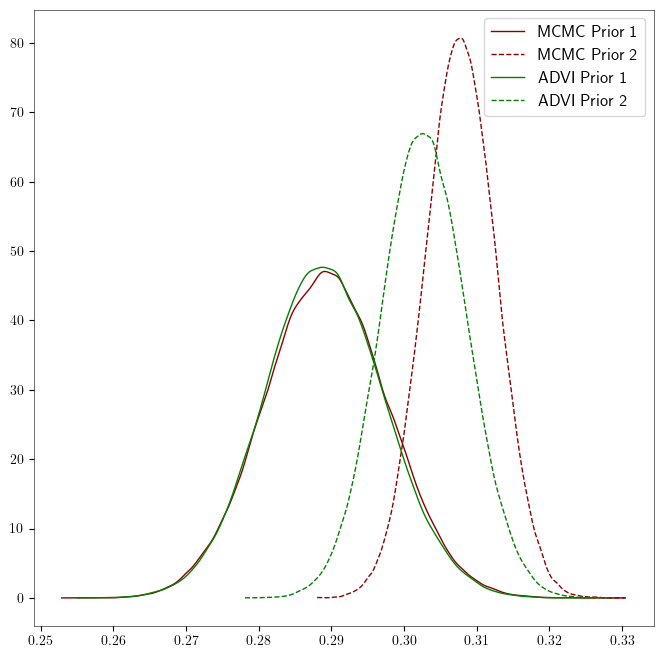

In [256]:
fig3, ax3 = plt.subplots(figsize=(8,8))
plot_results(lcdm_ei1p0.idata, 1000, ax=ax3, name='MCMC Prior 1', dist_kwargs={'color':'darkred', 'plot_kwargs':{'linewidth':1}})
plot_results(lcdm_ei1p1.idata, 1000, ax=ax3, name='MCMC Prior 2', dist_kwargs={'color':'darkred', 'plot_kwargs':{'linestyle':'dashed', 'linewidth':1}})
plot_results(lcdm_ni1p0.idata, 0, ax=ax3, name='ADVI Prior 1', dist_kwargs={'color':'green', 'plot_kwargs':{'linewidth':1}})
plot_results(lcdm_ni1p1.idata, 0, ax=ax3, name='ADVI Prior 2', dist_kwargs={'color':'green', 'plot_kwargs':{'linestyle':'dashed', 'linewidth':1}})

fig3.savefig('../plots/lcdm_comparison.pdf')

# Load CPL data

In [175]:
cpl_ni0p0 = numpyro_result(data_dir_num + 'cpl_prior0_init_0_0.001.pickle')
cpl_ni1p0 = numpyro_result(data_dir_num + 'cpl_prior0_init_1_0.001.pickle')
cpl_ni0p1 = numpyro_result(data_dir_num + 'cpl_prior1_init_0_0.001.pickle')
cpl_ni1p1 = numpyro_result(data_dir_num + 'cpl_prior1_init_1_0.001.pickle')
cpl_ni0p2 = numpyro_result(data_dir_num + 'cpl_prior2_init_0_0.001.pickle')
cpl_ni1p2 = numpyro_result(data_dir_num + 'cpl_prior2_init_1_0.001.pickle')

In [144]:
cpl_ei0p0 = emcee_result(data_dir_em +'cpl_init0_prior0.nc')
cpl_ei0p1 = emcee_result(data_dir_em +'cpl_init0_prior1.nc')
cpl_ei1p0 = emcee_result(data_dir_em +'cpl_init1_prior0.nc')
cpl_ei1p1 = emcee_result(data_dir_em +'cpl_init1_prior1.nc')
cpl_ei1p2 = emcee_result(data_dir_em +'cpl_init1_prior2.nc')

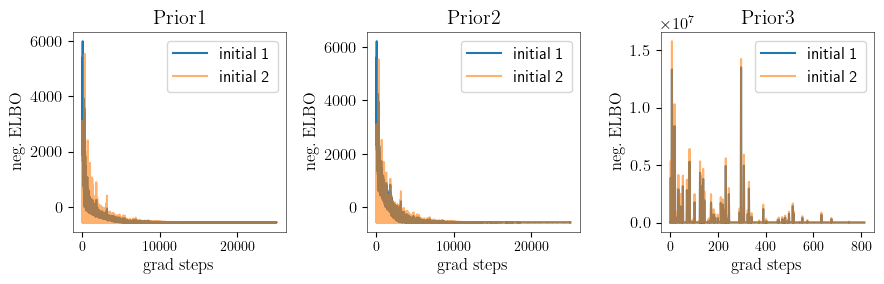

In [254]:
fig8, axes8 = plt.subplots(1,3, figsize=(9,3))

cpl_ni0p0.plot_losses(axes8[0], kwargs={'label':'initial 1', 'linewidth':1.5})  
cpl_ni1p0.plot_losses(axes8[0],kwargs={'label':'initial 2', 'alpha':0.6, 'linewidth':1.5})  
axes8[0].legend()
axes8[0].set_ylabel(r'$\mathrm{neg. \;ELBO}$')
axes8[0].set_xlabel(r'$\mathrm{grad\; steps}$')
axes8[0].set_title(r'$\mathrm{Prior 1}$')

 
cpl_ni0p1.plot_losses(axes8[1], kwargs={'label':'initial 1', 'linewidth':1.5})  
cpl_ni1p1.plot_losses(axes8[1],kwargs={'label':'initial 2', 'alpha':0.6, 'linewidth':1.5})  
axes8[1].legend()
axes8[1].set_ylabel(r'$\mathrm{neg. \;ELBO}$')
axes8[1].set_xlabel(r'$\mathrm{grad\; steps}$')
axes8[1].set_title(r'$\mathrm{Prior2}$')


cpl_ni0p2.plot_losses(axes8[2], kwargs={'label':'initial 1', 'linewidth':1.5})  
cpl_ni1p2.plot_losses(axes8[2],kwargs={'label':'initial 2', 'alpha':0.6, 'linewidth':1.5})  
axes8[2].legend()
axes8[2].set_ylabel(r'$\mathrm{neg. \;ELBO}$')
axes8[2].set_xlabel(r'$\mathrm{grad\; steps}$')
axes8[2].set_title(r'$\mathrm{Prior3}$')

fig8.tight_layout()
fig8.savefig('../plots/cpl_losses.pdf')

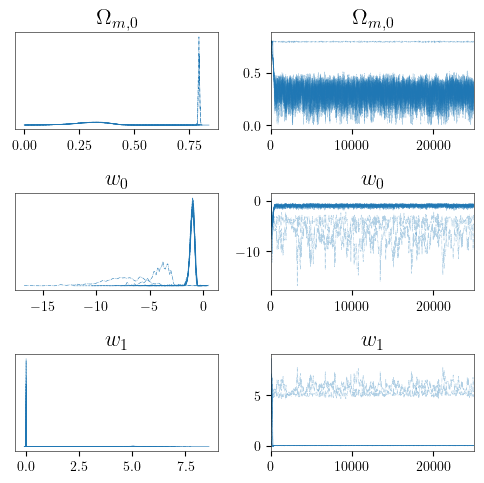

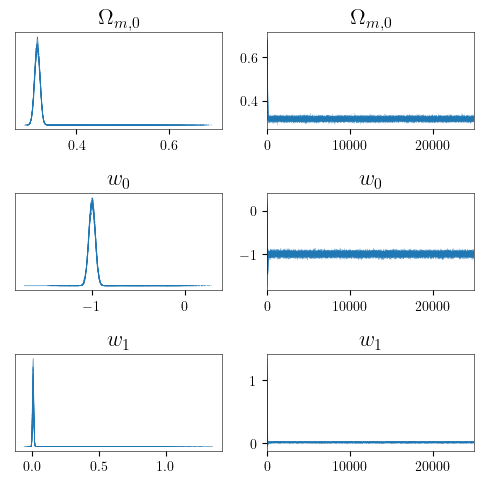

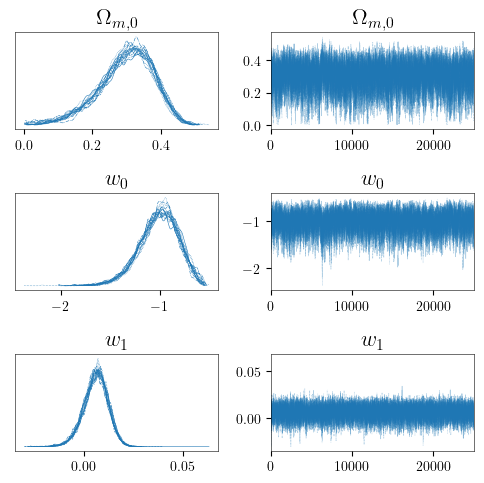

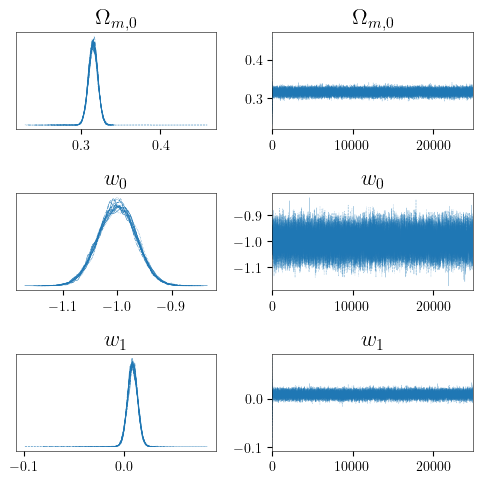

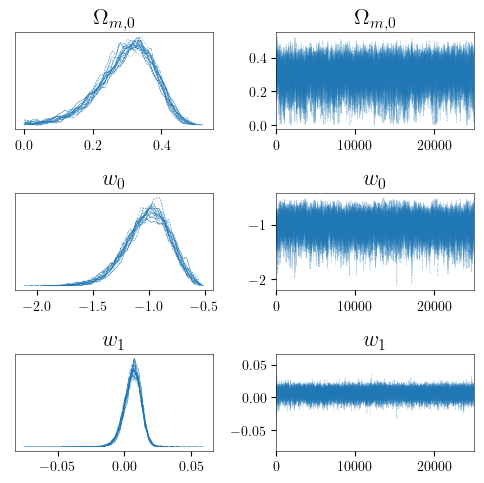

In [145]:
fig2, axes2 = plt.subplots(3,2, figsize=(5,5))
cpl_ei0p0.trace(axes=axes2)
plt.tight_layout()
fig2.savefig('../plots/cpl_ei0p0_trace.pdf')

fig3, axes3 = plt.subplots(3,2, figsize=(5,5))
cpl_ei0p1.trace(axes=axes3)
plt.tight_layout()
fig3.savefig('../plots/cpl_ei0p1_trace.pdf')

fig4, axes4 = plt.subplots(3,2, figsize=(5,5))
cpl_ei1p0.trace(axes=axes4)
plt.tight_layout()
fig4.savefig('../plots/cpl_ei1p0_trace.pdf')

fig5, axes5 = plt.subplots(3,2, figsize=(5,5))
cpl_ei1p1.trace(axes=axes5)
plt.tight_layout()
fig5.savefig('../plots/cpl_ei1p1_trace.pdf')

fig6, axes6 = plt.subplots(3,2, figsize=(5,5))
cpl_ei1p2.trace(axes=axes6)
plt.tight_layout()
fig6.savefig('../plots/cpl_ei1p2_trace.pdf')

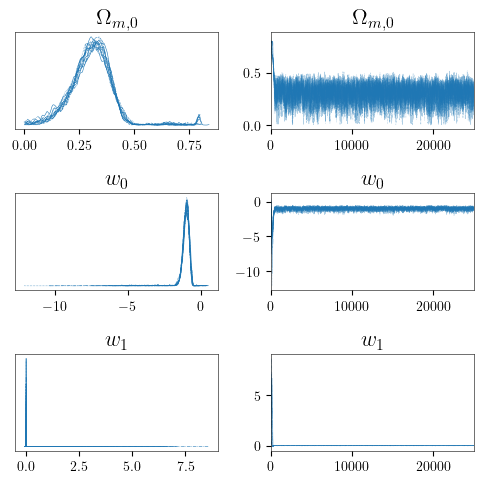

In [146]:
fig12, axes12 = plt.subplots(3,2, figsize=(5,5))
cpl_ei0p0.idata.sel(chain=[0,1,2,3,4,5,6,8,9,10,11,12,13,14], inplace=True)
cpl_ei0p0.trace(axes=axes12)
plt.tight_layout()

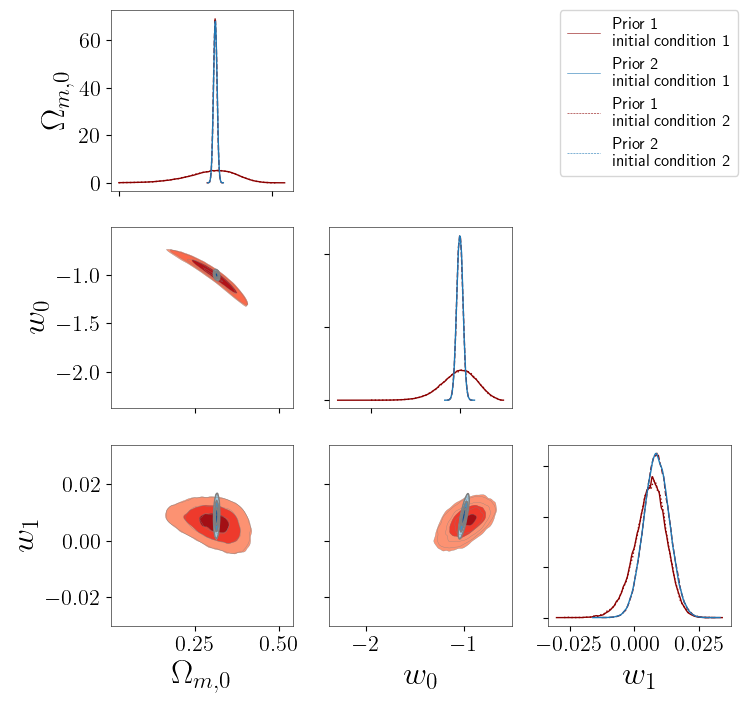

In [246]:
fig1, ax1 = plt.subplots(3,3,figsize=(8,8))
burnin_plot = 1000
plot_results(cpl_ei0p0.idata, burnin_plot, ax=ax1, 
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':':'}})
plot_results(cpl_ei0p1.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":1, "levels":3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':'--'}})
plot_results(cpl_ei1p0.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})
plot_results(cpl_ei1p1.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Blues", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "tab:blue",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})
#plot_results(cpl_ei1p2.idata, burnin_plot, ax=ax1,
#            kde_kwargs={"contourf_kwargs": {"cmap": "Blues"}, "contour_kwargs": {"linewidths":0.2}},
#            marginal_kwargs={"color": "tab:blue",'plot_kwargs':{'linewidth':1, 'linestyle':'-.'}})

h_i1p1 = mlines.Line2D([], [], color='darkred', label='Prior 1 \n initial condition 1')
h_i2p1 = mlines.Line2D([], [], color='tab:blue', label='Prior 2 \n initial condition 1')
h_i1p2 = mlines.Line2D([], [], color='darkred', linestyle='--', label='Prior 1 \n initial condition 2')
h_i2p2 = mlines.Line2D([], [], color='tab:blue', linestyle='--', label='Prior 2 \n initial condition 2')

fig1.legend(handles=(h_i1p1, h_i2p1, h_i1p2, h_i2p2), bbox_to_anchor=(0.4, 0.4, 0.52, 0.49));

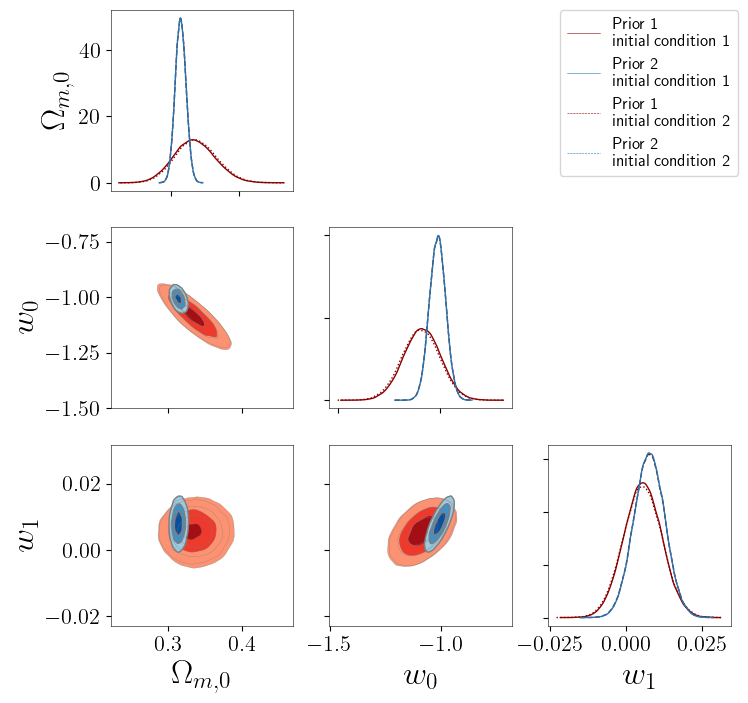

In [247]:
fig1, ax1 = plt.subplots(3,3,figsize=(8,8))
burnin_plot = 0
plot_results(cpl_ni0p0.idata, burnin_plot, ax=ax1, 
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':':'}})
plot_results(cpl_ni0p1.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":1, "levels":3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':'--'}})
plot_results(cpl_ni1p0.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})
plot_results(cpl_ni1p1.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Blues", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "tab:blue",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})


h_i1p1 = mlines.Line2D([], [], color='darkred', label='Prior 1 \n initial condition 1')
h_i2p1 = mlines.Line2D([], [], color='tab:blue', label='Prior 2 \n initial condition 1')
h_i1p2 = mlines.Line2D([], [], color='darkred', linestyle='--', label='Prior 1 \n initial condition 2')
h_i2p2 = mlines.Line2D([], [], color='tab:blue', linestyle='--', label='Prior 2 \n initial condition 2')

fig1.legend(handles=(h_i1p1, h_i2p1, h_i1p2, h_i2p2), bbox_to_anchor=(0.4, 0.4, 0.52, 0.49));

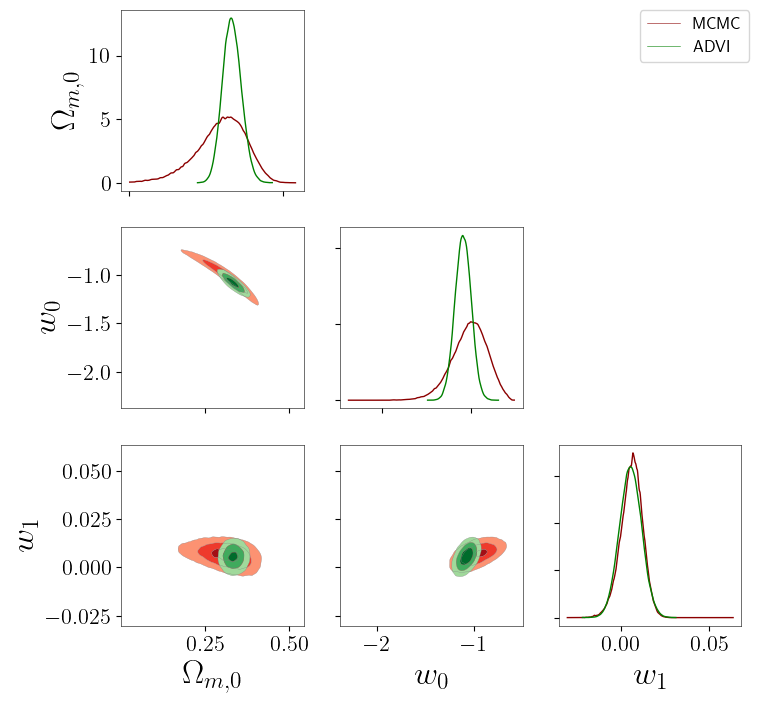

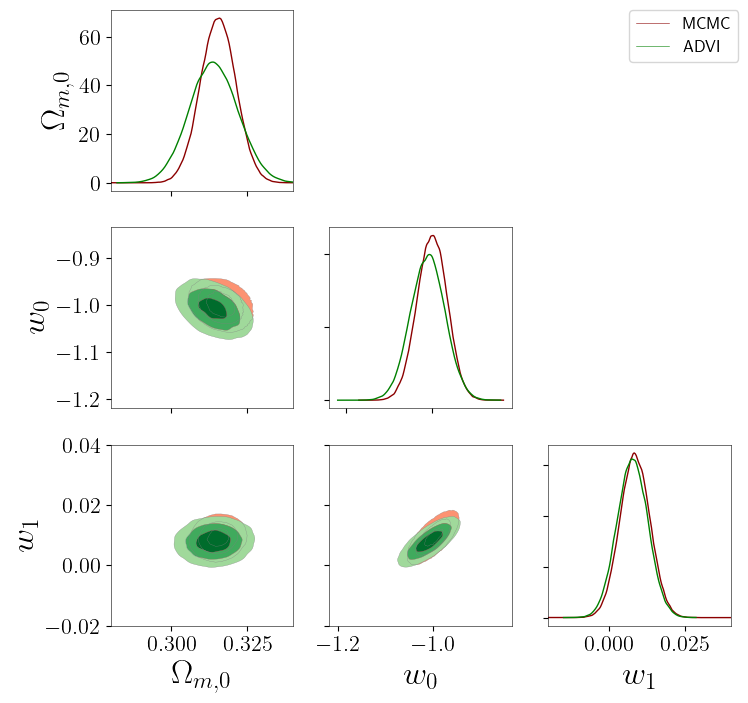

In [248]:
fig, ax = plt.subplots(3,3,figsize=(8,8))
fig1, ax1 = plt.subplots(3,3,figsize=(8,8))
[ax1[i,0].set_xlim(0.28, 0.34) for i in range(3)]
[ax1[2,i].set_ylim(-0.02, 0.04) for i in range(3)]
ax1[2,2].set_xlim(-0.02, 0.04)

plot_results(cpl_ei1p0.idata, burnin_plot, ax=ax,
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})
plot_results(cpl_ei1p1.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Reds", "levels":3}, "contour_kwargs": {"linewidths":0.2, 'levels':3}},
            marginal_kwargs={"color": "darkred",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})

plot_results(cpl_ni1p0.idata, burnin_plot, ax=ax,
            kde_kwargs={"contourf_kwargs": {"cmap": "Greens", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "green",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})
plot_results(cpl_ni1p1.idata, burnin_plot, ax=ax1,
            kde_kwargs={"contourf_kwargs": {"cmap": "Greens", "levels":3}, "contour_kwargs": {"linewidths":0.2, "levels":3}},
            marginal_kwargs={"color": "green",'plot_kwargs':{'linewidth':1, 'linestyle':'-'}})

h_mcmc = mlines.Line2D([], [], color='darkred', label='MCMC')
h_advi = mlines.Line2D([], [], color='green', label='ADVI')

fig.legend(handles=(h_mcmc, h_advi), bbox_to_anchor=(0.4, 0.4, 0.52, 0.49))
fig1.legend(handles=(h_mcmc, h_advi), bbox_to_anchor=(0.4, 0.4, 0.52, 0.49))

fig.savefig('../plots/comparison_prior_1.pdf')
fig1.savefig('../plots/comparison_prior_planck.pdf')

(24900.0, 25000.0)

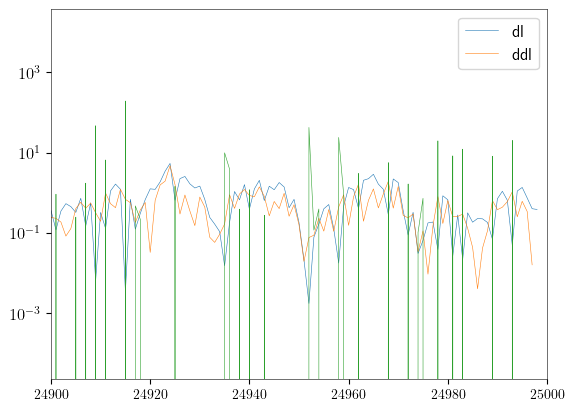

In [225]:
l = jnp.array(cpl_ni1p1.losses)
dl = abs(jnp.diff(l))
ddl = abs(jnp.diff(dl))

#plt.plot(l)
plt.plot(dl, label='dl')
plt.plot(ddl, label='ddl')
plt.plot(ddl/dl[:-1] - 1)
plt.legend()
plt.yscale('log')
plt.xlim(24900,25000)